d:\Anaconda3\envs\baks\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\Anaconda3\envs\baks\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda3\envs\baks\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


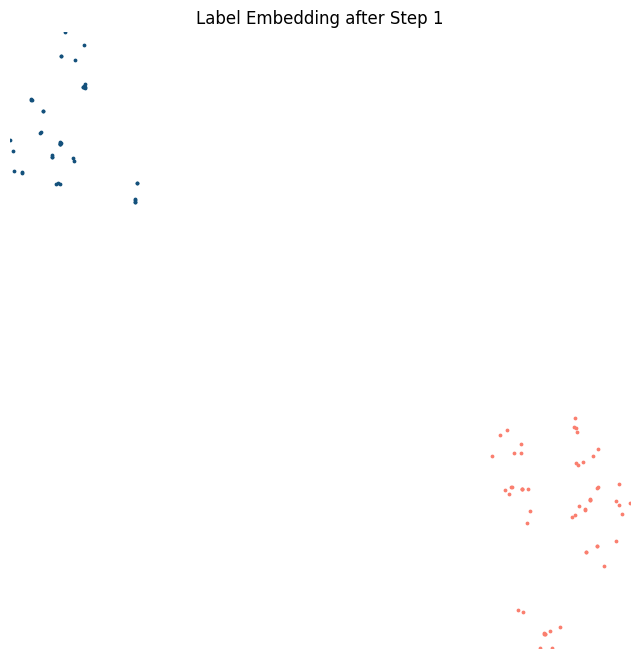

d:\Anaconda3\envs\baks\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda3\envs\baks\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


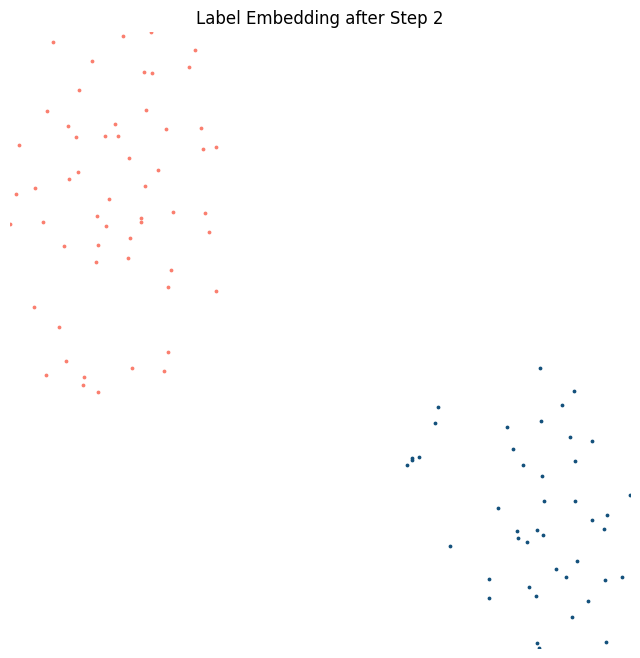

d:\Anaconda3\envs\baks\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda3\envs\baks\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


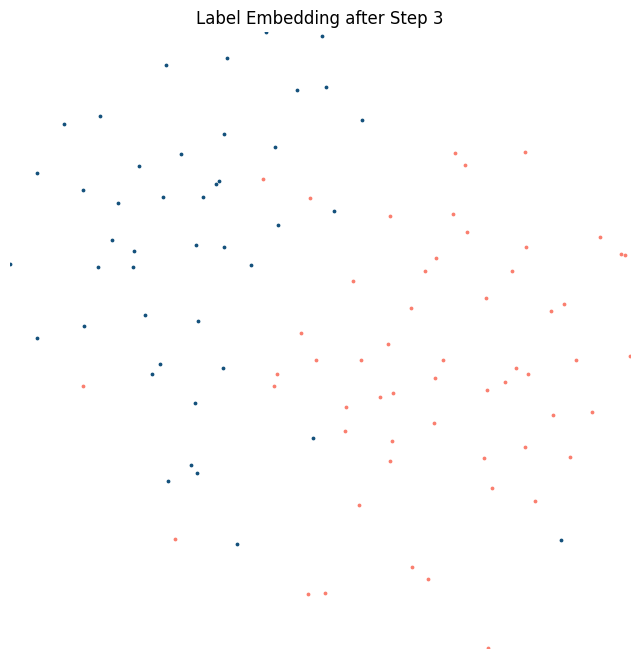

d:\Anaconda3\envs\baks\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
d:\Anaconda3\envs\baks\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


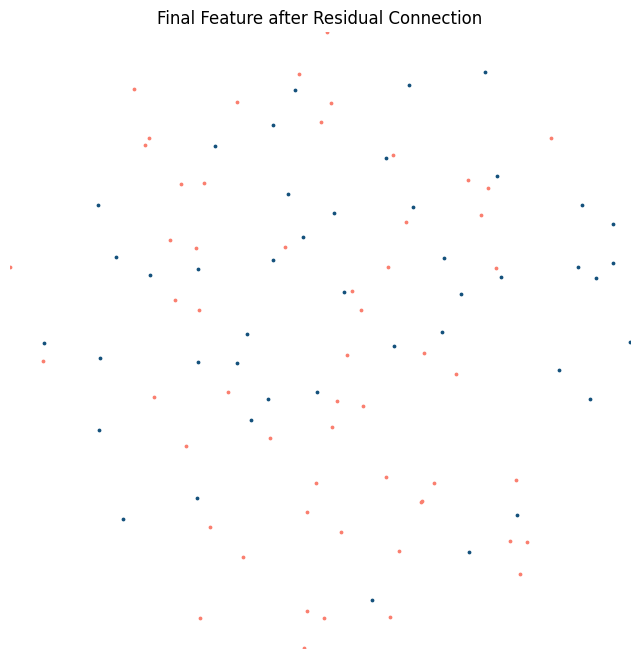

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x32 and 128x32)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

# 假设这是 GTAN 模型的 forward 方法
class GraphAttnModel(nn.Module):
    def __init__(self, in_feats, hidden_dim, n_layers, n_classes, heads, activation, drop=None):
        super(GraphAttnModel, self).__init__()
        self.in_feats = in_feats
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.n_classes = n_classes
        self.heads = heads
        self.activation = activation
        self.input_drop = nn.Dropout(drop[0])
        self.drop = drop[1]
        self.output_drop = nn.Dropout(self.drop)
        self.layers = nn.ModuleList()
        self.layers.append(nn.Embedding(n_classes+1, in_feats, padding_idx=n_classes))
        self.layers.append(nn.Linear(self.in_feats, self.hidden_dim*self.heads[0]))
        self.layers.append(nn.Linear(self.in_feats, self.hidden_dim*self.heads[0]))
        self.layers.append(nn.Sequential(nn.BatchNorm1d(self.hidden_dim*self.heads[0]),
                                         nn.PReLU(),
                                         nn.Dropout(self.drop),
                                         nn.Linear(self.hidden_dim * self.heads[0], in_feats)
                                         ))
        # 构建多个层
        for l in range(0, (self.n_layers)):
            # 由于多头注意力，输入维度 = 隐藏维度 * 头数
            self.layers.append(nn.Linear(self.in_feats if l == 0 else self.hidden_dim * self.heads[l - 1],
                                         self.hidden_dim, bias=False))

    def forward(self, blocks, features, labels, n2v_feat=None, visualize=False):
        if n2v_feat is None:
            h = features
        else:
            h = features + n2v_feat

        label_embed = self.input_drop(self.layers[0](labels))
        label_embed_1 = label_embed.clone().detach().cpu().numpy()

        label_embed = self.layers[1](h) + self.layers[2](label_embed)
        label_embed_2 = label_embed.clone().detach().cpu().numpy()

        label_embed = self.layers[3](label_embed)
        label_embed_3 = label_embed.clone().detach().cpu().numpy()

        h = h + label_embed  # 残差连接
        h_final = h.clone().detach().cpu().numpy()

        if visualize:
            self.visualize(label_embed_1, label_embed_2, label_embed_3, h_final, labels)

        for l in range(self.n_layers):
            h = self.output_drop(self.layers[l+4](h))

        logits = self.layers[-1](h)

        return logits

    def visualize(self, label_embed_1, label_embed_2, label_embed_3, h_final, labels):
        labels = labels.cpu().numpy()

        def plot_embedding(embedding, title):
            tsne = TSNE(n_components=2, random_state=43)
            X_reduced = tsne.fit_transform(embedding)

            scaler = MinMaxScaler(feature_range=(0, 1))
            X_scaled = scaler.fit_transform(X_reduced)

            plt.figure(figsize=(8, 8))
            plt.scatter(X_scaled[labels == 0, 0], X_scaled[labels == 0, 1], c='#14517C', label='Label 0', s=3)
            plt.scatter(X_scaled[labels == 1, 0], X_scaled[labels == 1, 1], c='#FA7F6F', label='Label 1', s=3)

            ax = plt.gca()
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['bottom'].set_visible(False)

            plt.xticks([])
            plt.yticks([])
            plt.xlim(0, 1)
            plt.ylim(0, 1)
            plt.title(title)
            plt.show()

        plot_embedding(label_embed_1, 'Label Embedding after Step 1')
        plot_embedding(label_embed_2, 'Label Embedding after Step 2')
        plot_embedding(label_embed_3, 'Label Embedding after Step 3')
        plot_embedding(h_final, 'Final Feature after Residual Connection')


# 示例使用
in_feats = 16
hidden_dim = 32
n_layers = 2
n_classes = 2
heads = [4]
activation = nn.PReLU()
drop = [0.2, 0.2]

model = GraphAttnModel(in_feats, hidden_dim, n_layers, n_classes, heads, activation, drop)

# 生成示例数据
features = torch.randn(100, in_feats)
labels = torch.randint(0, n_classes, (100,))
blocks = None
n2v_feat = None

# 前向传播并可视化
logits = model(blocks, features, labels, n2v_feat, visualize=True)